In [1]:
import numpy as np
import pandas as pd
import nfft
import pickle
from scipy import interpolate
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
from pylab import *
matplotlib.style.use('classic')
VFont=18
matplotlib.rcParams['figure.facecolor'] = '1.0'

#matplotlib.rcParams['mathtext.fontset'] = 'dejavusans'
#matplotlib.rcParams['font.family'] = 'DejaVu Sans'
#matplotlib.rcParams['font.sans-serif'] = 'dejavusans'

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

matplotlib.rcParams['axes.titlesize'] = VFont
matplotlib.rcParams['axes.labelsize'] = VFont
matplotlib.rcParams['xtick.labelsize'] = VFont*0.9
matplotlib.rcParams['ytick.labelsize'] = VFont*0.9
matplotlib.rcParams['legend.fontsize'] = VFont*0.9
matplotlib.rcParams['axes.formatter.useoffset'] = False
matplotlib.rcParams['savefig.directory'] = ""
matplotlib.rcParams['savefig.format'] = 'pdf'

In [3]:
def new_fig( NewSet = False, FigSIZE = (9,5), FigDPI = 82 ):
    if NewSet:
        new_fig.set = new_fig.set + 100
        new_fig.num = 1
    else:
        new_fig.num = new_fig.num + 1

    figure( new_fig.set + new_fig.num, figsize=FigSIZE, dpi = FigDPI )
    subplots_adjust( top = 0.93, bottom = 0.12, left = 0.10, right=0.96,\
                     hspace = 0.2, wspace = 0.2 )
    return new_fig.num

# create a "new_fig" function counter (kind of static variable)
new_fig.num = 0
new_fig.set = 100

In [4]:
MonthsName = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
              'September', 'October', 'November', 'December']
MonthsDays = np.array( [ 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31 ] )
TotalHours = MonthsDays.sum()*24.0

Tide data retrieved from
https://webpages.ciencias.ulisboa.pt/~cmantunes/hidrografia/hidro_mares.html

In [11]:
df=pd.read_excel('Mares_2020_Hourly.xlsx', "January" )
df.keys()

Index(['hours/days',            1,            2,            3,            4,
                  5,            6,            7,            8,            9,
                 10,           11,           12,           13,           14,
                 15,           16,           17,           18,           19,
                 20,           21,           22,           23,           24,
                 25,           26,           27,           28,           29,
                 30,           31],
      dtype='object')

In [6]:
Annual_Time = []
Annual_Height = []

ElapsedDays  = 0

for Nm, Name in enumerate( MonthsName ):
    df = pd.read_excel('Mares_2020_Hourly.xlsx', Name )
    
    for Nd in range( MonthsDays[Nm] ):
        # print( Nm+1, Name, Nd+1 )
        Height = df[ Nd+1 ]
        for Nh in range( 24 ):
            h = Height[Nh]
            t = ElapsedDays * 24.0 + Nh
            Annual_Time.append( t )
            Annual_Height.append( h )

        ElapsedDays += 1

Annual_Time = np.array( Annual_Time )

Annual_Height = np.array( Annual_Height )
# remove the mean surface water level
Annual_Height -= np.mean( Annual_Height )

(1200.0, 1320.0)

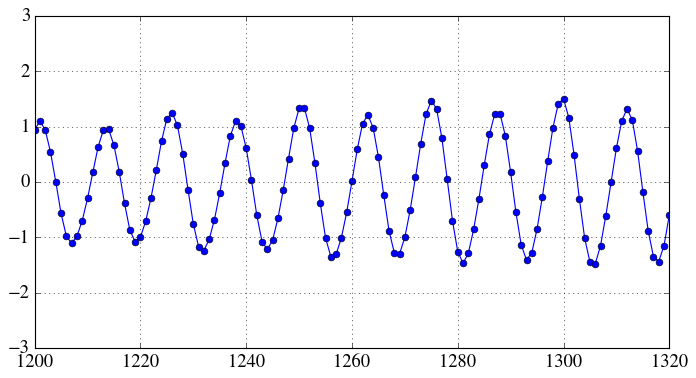

In [14]:
# plot the tide
new_fig()
plot(Annual_Time,Annual_Height,'o-')
grid(which='both')
xlim( 1200, 1200+24*5 )

(0.0001454441043328608, 1.246710378497756)

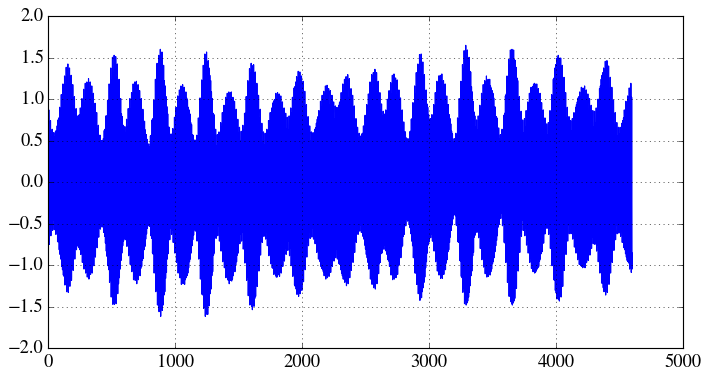

In [8]:
# define a dimensionless tide
new_fig()
mean_Amp = np.sqrt(2.0) * Annual_Height.std()
omega_ref = 2.0*np.pi / (12.00*3600.0) 
Annual_Height_Star = Annual_Height / mean_Amp
Annual_Time_Star = (Annual_Time*3600.0) * omega_ref # convert Annual_Time to seconds
plot(Annual_Time_Star,Annual_Height_Star)
grid(which='both')
pickle.dump( (omega_ref,mean_Amp,Annual_Time_Star,Annual_Height_Star), 
                open( "TideLisbonStar.p", "wb" ) )
omega_ref, mean_Amp

(1, 10000)

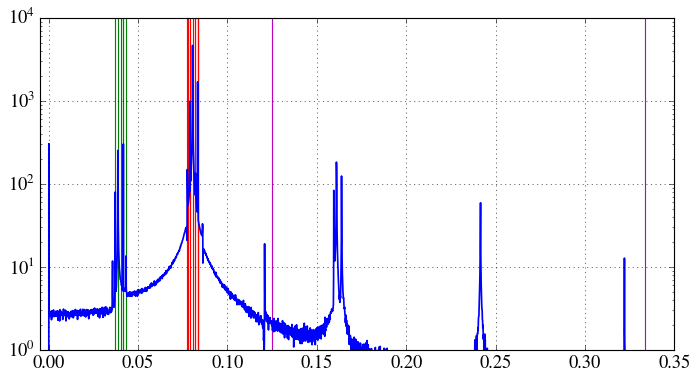

In [9]:
W = fftfreq(Annual_Height.size, d=Annual_Time[1]-Annual_Time[0])

fsample = 1.0
delta_f = fsample / Annual_Height.size
Freqs = delta_f * np.array( range( Annual_Height.size ) )
f_hat = fft(Annual_Height)
new_fig()

semi_diurnal = ( 12.42,12.00,12.66,11.97,12.0,12.19,12.91,12.63,12.22,12.87 )
diurnal = ( 23.93,25.82,24.07,26.87,24.86,23.1 )

for T in semi_diurnal:
    gca().axvline( 1.0/T, color='r' )
for T in diurnal:
    gca().axvline( 1.0/T, color='g' )

gca().axvline( 1.0/8., color='m' )
gca().axvline( 1.0/3., color='m' )

#%matplotlib qt 
grid()
semilogy( Freqs, np.abs( f_hat ),lw=1.5 )
xlim( -0.005, 0.35 )
#xlim( 0.07, 0.09 )
ylim(1,10000)

(1300.0, 1340.0)

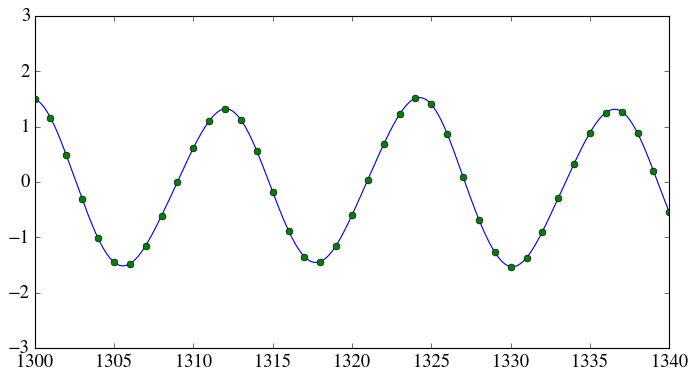

In [10]:
new_fig()
CS = interpolate.CubicSpline( Annual_Time, Annual_Height, bc_type='clamped' )
tnew = np.linspace(0, Annual_Time[-1], Annual_Height.size*60 )
out = CS(tnew)
plt.plot( tnew, out )
plot(Annual_Time,Annual_Height,'o')
xlim((1300,1340))